<a href="https://colab.research.google.com/github/aaronbbarclay/mine/blob/master/DensePose.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pose Detection with DensePose

This notebook uses an open source project [facebookresearch/DensePose](https://github.com/facebookresearch/DensePose) to detect multi person poses on a test image.

For other deep-learning Colab notebooks, visit [tugstugi/dl-colab-notebooks](https://github.com/tugstugi/dl-colab-notebooks).


## Install DensePose

Installing the DensePose seems to be very tricky. For more information, see [http://linkinpark213.com/2018/11/18/densepose-minesweeping/](http://linkinpark213.com/2018/11/18/densepose-minesweeping/).

First, we are going to install an Anaconda with some fixed dependencies:

In [1]:
import os
from os.path import exists, join, basename, splitext

# install Anaconda Python 2.7 to control the dependencies
# see for more info: 
if not exists('anaconda2'):
  !wget -q https://repo.anaconda.com/archive/Anaconda2-2018.12-Linux-x86_64.sh
  !chmod +x Anaconda2-2018.12-Linux-x86_64.sh
  !bash ./Anaconda2-2018.12-Linux-x86_64.sh -b -f -p /content/anaconda2
  # set PATH environment variable
  os.environ['PATH'] = "/content/anaconda2/bin:" + os.environ['PATH']
  # install PyTorch
  !conda install -y mkl-include
  !conda install -y pytorch=1.0.1 torchvision cudatoolkit=10.0 -c pytorch
  !ln -s /content/anaconda2/lib/python2.7/site-packages/torch/lib/ /content/anaconda2/lib/python2.7/site-packages/
  # install GCC 4.9
  !conda install -y -c serge-sans-paille gcc_49
  !ln -fs /content/anaconda2/lib/libmpfr.so /content/anaconda2/lib/libmpfr.so.4
  os.environ['CC'] = '/content/anaconda2/bin/gcc-4.9'
  os.environ['CXX'] = '/content/anaconda2/bin/g++-4.9'
  # protobuf 3.5
  #!apt-get -qq remove -y protobuf-compiler
  !conda install -y protobuf=3.5
  # pycocotools
  !conda install -y -c conda-forge pycocotools
  
# we need some headers from the pytorch source
if not exists('pytorch'):
  !git clone -q --depth 1 --recursive -b v1.0.1 https://github.com/pytorch/pytorch

PREFIX=/content/anaconda2
installing: python-2.7.15-h9bab390_6 ...
Python 2.7.15 :: Anaconda, Inc.
installing: blas-1.0-mkl ...
installing: ca-certificates-2018.03.07-0 ...
installing: conda-env-2.6.0-1 ...
installing: intel-openmp-2019.1-144 ...
installing: libgcc-ng-8.2.0-hdf63c60_1 ...
installing: libgfortran-ng-7.3.0-hdf63c60_0 ...
installing: libstdcxx-ng-8.2.0-hdf63c60_1 ...
installing: bzip2-1.0.6-h14c3975_5 ...
installing: expat-2.2.6-he6710b0_0 ...
installing: fribidi-1.0.5-h7b6447c_0 ...
installing: gmp-6.1.2-h6c8ec71_1 ...
installing: graphite2-1.3.12-h23475e2_2 ...
installing: icu-58.2-h9c2bf20_1 ...
installing: jbig-2.1-hdba287a_0 ...
installing: jpeg-9b-h024ee3a_2 ...
installing: libffi-3.2.1-hd88cf55_4 ...
installing: liblief-0.9.0-h7725739_1 ...
installing: libsodium-1.0.16-h1bed415_0 ...
installing: libtool-2.4.6-h7b6447c_5 ...
installing: libuuid-1.0.3-h1bed415_2 ...
installing: libxcb-1.13-h1bed415_1 ...
installing: lz4-c-1.8.1.2-h14c3975_0 ...
installing: lzo-2.10-h

Check whether the system dependencies are installed correctly:

In [2]:
# some sanity checks
!conda --version
!protoc --version
!gcc-4.9 --version

conda 4.6.14
libprotoc 3.5.1
gcc-4.9 (GCC) 4.9.1
Copyright (C) 2014 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



Clone the DensePose project and build it:

In [39]:
import os
from os.path import exists, join, basename, splitext

git_repo_url = 'https://github.com/facebookresearch/DensePose.git'
project_name = splitext(basename(git_repo_url))[0]
if not exists(project_name):
  # clone project
  !git clone -q --depth 1 $git_repo_url
  # install dependencies
  !cd $project_name && pip install -q -r requirements.txt
  # update CMakeLists.txt
  cmakelists_txt_content = """
cmake_minimum_required(VERSION 2.8.12 FATAL_ERROR)
set(Caffe2_DIR "/content/anaconda2/lib/python2.7/site-packages/torch/share/cmake/Caffe2/")
find_package(Caffe2 REQUIRED)

include_directories("/content/anaconda2/lib/python2.7/site-packages/torch/lib/include")
include_directories("/content/anaconda2/include")
include_directories("/content/pytorch")

add_library(libprotobuf STATIC IMPORTED)
set(PROTOBUF_LIB "/content/anaconda2/lib/libprotobuf.a")
set_property(TARGET libprotobuf PROPERTY IMPORTED_LOCATION "${PROTOBUF_LIB}")

if (${CAFFE2_VERSION} VERSION_LESS 0.8.2)
  # Pre-0.8.2 caffe2 does not have proper interface libraries set up, so we
  # will rely on the old path.
  message(WARNING
      "You are using an older version of Caffe2 (version " ${CAFFE2_VERSION}
      "). Please consider moving to a newer version.")
  include(cmake/legacy/legacymake.cmake)
  return()
endif()

# Add compiler flags.
set(CMAKE_C_FLAGS "${CMAKE_C_FLAGS} -std=c11")
set(CMAKE_CXX_FLAGS "${CMAKE_CXX_FLAGS} -std=c++11 -O2 -fPIC -Wno-narrowing")

# Print configuration summary.
include(cmake/Summary.cmake)
detectron_print_config_summary()

# Collect custom ops sources.
file(GLOB CUSTOM_OPS_CPU_SRCS ${CMAKE_CURRENT_SOURCE_DIR}/detectron/ops/*.cc)
file(GLOB CUSTOM_OPS_GPU_SRCS ${CMAKE_CURRENT_SOURCE_DIR}/detectron/ops/*.cu)

# Install custom CPU ops lib.
add_library(
     caffe2_detectron_custom_ops SHARED
     ${CUSTOM_OPS_CPU_SRCS})

target_link_libraries(caffe2_detectron_custom_ops caffe2_library libprotobuf)
install(TARGETS caffe2_detectron_custom_ops DESTINATION lib)

# Install custom GPU ops lib, if gpu is present.
if (CAFFE2_USE_CUDA OR CAFFE2_FOUND_CUDA)
  # Additional -I prefix is required for CMake versions before commit (< 3.7):
  # https://github.com/Kitware/CMake/commit/7ded655f7ba82ea72a82d0555449f2df5ef38594
  list(APPEND CUDA_INCLUDE_DIRS -I${CAFFE2_INCLUDE_DIRS})
  CUDA_ADD_LIBRARY(
      caffe2_detectron_custom_ops_gpu SHARED
      ${CUSTOM_OPS_CPU_SRCS}
      ${CUSTOM_OPS_GPU_SRCS})

  target_link_libraries(caffe2_detectron_custom_ops_gpu caffe2_gpu_library libprotobuf)
  install(TARGETS caffe2_detectron_custom_ops_gpu DESTINATION lib)
endif()"""
  open(join(project_name, 'CMakeLists.txt'), 'w').write(cmakelists_txt_content)
  # build
  !cd $project_name && make
  !cd $project_name && make ops
  # download dense pose data
  !cd $project_name/DensePoseData && bash get_densepose_uv.sh

python2 setup.py develop --user
Compiling detectron/utils/cython_bbox.pyx because it changed.
Compiling detectron/utils/cython_nms.pyx because it changed.
[1/2] Cythonizing detectron/utils/cython_bbox.pyx
/usr/local/lib/python2.7/dist-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/data/densePose_vid2/infer_out/DensePose/detectron/utils/cython_bbox.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
[2/2] Cythonizing detectron/utils/cython_nms.pyx
/usr/local/lib/python2.7/dist-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/data/densePose_vid2/infer_out/DensePose/detectron/utils/cython_nms.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
running develop
running egg_info
creating Detectron.egg-info
writing Detectron.egg-info/PKG-INFO


Check whether the DensePose installation was successful:

In [40]:
!python2 $project_name/detectron/tests/test_spatial_narrow_as_op.py
!python2 $project_name/detectron/tests/test_zero_even_op.py

[E init_intrinsics_check.cc:43] CPU feature avx is present on your machine, but the Caffe2 binary is not compiled with it. It means you may not get the full speed of your CPU.
[E init_intrinsics_check.cc:43] CPU feature avx2 is present on your machine, but the Caffe2 binary is not compiled with it. It means you may not get the full speed of your CPU.
[E init_intrinsics_check.cc:43] CPU feature fma is present on your machine, but the Caffe2 binary is not compiled with it. It means you may not get the full speed of your CPU.
Traceback (most recent call last):
  File "DensePose/detectron/tests/test_spatial_narrow_as_op.py", line 80, in <module>
    c2_utils.import_detectron_ops()
  File "/content/data/densePose_vid2/infer_out/DensePose/detectron/utils/c2.py", line 33, in import_detectron_ops
    detectron_ops_lib = envu.get_detectron_ops_lib()
  File "/content/data/densePose_vid2/infer_out/DensePose/detectron/utils/env.py", line 63, in get_detectron_ops_lib
    ('Detectron ops lib not fou

In [5]:


#Mount Google Drive as folder
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [17]:
%ls
%cd /content/ 
!mkdir -p /content/data/densepose/infer_out
!mkdir -p /content/data/densepose/src/
!cp -r /content/drive/My\ Drive/MachineLearning/trainingSets/myRandomStuff_v1/densepose/* /content/data/densepose/src/.
%cd /content/data/densepose/src
%ls

/content
/content/data/densepose/src
_DSC0194.jpg  _DSC0566.jpg  _DSC1230.jpg  _DSC6563.jpg  _MG_9840.jpg
_DSC0208.jpg  _DSC0606.jpg  _DSC1467.jpg  _MG_0929.jpg
_DSC0241.jpg  _DSC0684.jpg  _DSC6282.jpg  _MG_0969.jpg


In [0]:
!mkdir -p /content/data/densePose_vid2
!cp -r /content/drive/My\ Drive/MachineLearning/trainingSets/myRandomStuff_v1/densePose_vid2/ /content/data/

In [12]:
%cd /content/data/densePose_vid2/src
%ls
#!rm *jpg 
!ffmpeg -y -i /content/data/densePose_vid2/src/IMG_1639.MOV IMG_1369_%05d.jpg 

#%ls

/content/data/densePose_vid2/src
IMG_1639.MOV
ffmpeg version 3.4.6-0ubuntu0.18.04.1 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.3.0-16ubuntu3)
  configuration: --prefix=/usr --extra-version=0ubuntu0.18.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-l

In [13]:
%cd /content/data/densePose_vid2/src
%ls

/content/data/densePose_vid2/src
IMG_1369_00001.jpg  IMG_1369_00090.jpg  IMG_1369_00179.jpg  IMG_1369_00268.jpg
IMG_1369_00002.jpg  IMG_1369_00091.jpg  IMG_1369_00180.jpg  IMG_1369_00269.jpg
IMG_1369_00003.jpg  IMG_1369_00092.jpg  IMG_1369_00181.jpg  IMG_1369_00270.jpg
IMG_1369_00004.jpg  IMG_1369_00093.jpg  IMG_1369_00182.jpg  IMG_1369_00271.jpg
IMG_1369_00005.jpg  IMG_1369_00094.jpg  IMG_1369_00183.jpg  IMG_1369_00272.jpg
IMG_1369_00006.jpg  IMG_1369_00095.jpg  IMG_1369_00184.jpg  IMG_1369_00273.jpg
IMG_1369_00007.jpg  IMG_1369_00096.jpg  IMG_1369_00185.jpg  IMG_1369_00274.jpg
IMG_1369_00008.jpg  IMG_1369_00097.jpg  IMG_1369_00186.jpg  IMG_1369_00275.jpg
IMG_1369_00009.jpg  IMG_1369_00098.jpg  IMG_1369_00187.jpg  IMG_1369_00276.jpg
IMG_1369_00010.jpg  IMG_1369_00099.jpg  IMG_1369_00188.jpg  IMG_1369_00277.jpg
IMG_1369_00011.jpg  IMG_1369_00100.jpg  IMG_1369_00189.jpg  IMG_1369_00278.jpg
IMG_1369_00012.jpg  IMG_1369_00101.jpg  IMG_1369_00190.jpg  IMG_1369_00279.jpg
IMG_1369_00013.jpg 

In [86]:
basePath = "/content/data/densePose_vid2/src"
filesToProcess = ["{0}/{1}".format(basePath, x) for x in os.listdir(basePath)]
print(filesToProcess)

['/content/data/densePose_vid1/src/IMG_0357.00090.jpg', '/content/data/densePose_vid1/src/IMG_0357.00186.jpg', '/content/data/densePose_vid1/src/IMG_0357.00158.jpg', '/content/data/densePose_vid1/src/IMG_0357.00138.jpg', '/content/data/densePose_vid1/src/IMG_0357.00166.jpg', '/content/data/densePose_vid1/src/IMG_0357.00045.jpg', '/content/data/densePose_vid1/src/IMG_0357.00006.jpg', '/content/data/densePose_vid1/src/IMG_0357.00108.jpg', '/content/data/densePose_vid1/src/IMG_0357.00011.jpg', '/content/data/densePose_vid1/src/IMG_0357.00119.jpg', '/content/data/densePose_vid1/src/IMG_0357.00172.jpg', '/content/data/densePose_vid1/src/IMG_0357.00020.jpg', '/content/data/densePose_vid1/src/IMG_0357.00054.jpg', '/content/data/densePose_vid1/src/IMG_0357.00038.jpg', '/content/data/densePose_vid1/src/IMG_0357.00167.jpg', '/content/data/densePose_vid1/src/IMG_0357.00053.jpg', '/content/data/densePose_vid1/src/IMG_0357.00185.jpg', '/content/data/densePose_vid1/src/IMG_0357.00171.jpg', '/content

In [27]:
%cd /content/
%cd DensePose/
%ls


/content
/content/DensePose
build/              CONTRIBUTING.md      INSTALL.md    PoseTrack/
challenge/          DensePoseData/       LICENSE       README.md
cmake/              detectron/           Makefile      requirements.txt
CMakeLists.txt      Detectron.egg-info/  MODEL_ZOO.md  setup.py
CODE_OF_CONDUCT.md  docker/              notebooks/    tools/
configs/            GETTING_STARTED.md   NOTICE
Traceback (most recent call last):
  File "/content/DensePose/tools/infer_simple.py", line 34, in <module>
    import detectron.core.test_engine as infer_engine
  File "/content/DensePose/detectron/core/test_engine.py", line 27, in <module>
    from detectron.core.rpn_generator import generate_rpn_on_dataset
  File "/content/DensePose/detectron/core/rpn_generator.py", line 36, in <module>
    from detectron.modeling import model_builder
  File "/content/DensePose/detectron/modeling/model_builder.py", line 38, in <module>
    from detectron.modeling.detector import DetectionModelHelper
  F

## Detect poses on a test image

Detect poses on the test image `demo_im.jpg` which is included in the DensePose repo:

In [35]:
%cd /content/DensePose/
#DIR_TO_PROCESS = "/content/data/densepose/src/"
#/content/data/densePose_vid1/src/
!mkdir -p /content/data/densePose_vid2/infer_out/
%pwd
%ls

!python2 /content/DensePose/tools/infer_simple.py \
            --cfg configs/DensePose_ResNet101_FPN_s1x-e2e.yaml \
            --output-dir /content/data/densePose_vid2/infer_out/ \
            --image-ext jpg \
            --wts https://dl.fbaipublicfiles.com/densepose/DensePose_ResNet101_FPN_s1x-e2e.pkl \
            /content/data/densePose_vid2/src/
    


/content/DensePose
build/              CONTRIBUTING.md      INSTALL.md    PoseTrack/
challenge/          DensePoseData/       LICENSE       README.md
cmake/              detectron/           Makefile      requirements.txt
CMakeLists.txt      Detectron.egg-info/  MODEL_ZOO.md  setup.py
CODE_OF_CONDUCT.md  docker/              notebooks/    tools/
configs/            GETTING_STARTED.md   NOTICE
Traceback (most recent call last):
  File "/content/DensePose/tools/infer_simple.py", line 34, in <module>
    import detectron.core.test_engine as infer_engine
  File "/content/DensePose/detectron/core/test_engine.py", line 27, in <module>
    from detectron.core.rpn_generator import generate_rpn_on_dataset
  File "/content/DensePose/detectron/core/rpn_generator.py", line 36, in <module>
    from detectron.modeling import model_builder
  File "/content/DensePose/detectron/modeling/model_builder.py", line 38, in <module>
    from detectron.modeling.detector import DetectionModelHelper
  File "/con

In [37]:
%cd /content/data/densePose_vid2/infer_out/
%ls -l 

os.path.isfile("/content/DensePose/tools/infer_simple.py")

/content/data/densePose_vid2/infer_out
total 0


True

Visualize the result:

['/content/data/densePose_vid1/src/IMG_0357_00001.jpg', '/content/data/densePose_vid1/src/IMG_0357_00002.jpg', '/content/data/densePose_vid1/src/IMG_0357_00003.jpg', '/content/data/densePose_vid1/src/IMG_0357_00004.jpg', '/content/data/densePose_vid1/src/IMG_0357_00005.jpg', '/content/data/densePose_vid1/src/IMG_0357_00006.jpg', '/content/data/densePose_vid1/src/IMG_0357_00007.jpg', '/content/data/densePose_vid1/src/IMG_0357_00008.jpg', '/content/data/densePose_vid1/src/IMG_0357_00009.jpg', '/content/data/densePose_vid1/src/IMG_0357_00010.jpg', '/content/data/densePose_vid1/src/IMG_0357_00011.jpg', '/content/data/densePose_vid1/src/IMG_0357_00012.jpg', '/content/data/densePose_vid1/src/IMG_0357_00013.jpg', '/content/data/densePose_vid1/src/IMG_0357_00014.jpg', '/content/data/densePose_vid1/src/IMG_0357_00015.jpg', '/content/data/densePose_vid1/src/IMG_0357_00016.jpg', '/content/data/densePose_vid1/src/IMG_0357_00017.jpg', '/content/data/densePose_vid1/src/IMG_0357_00018.jpg', '/content

KeyboardInterrupt: ignored

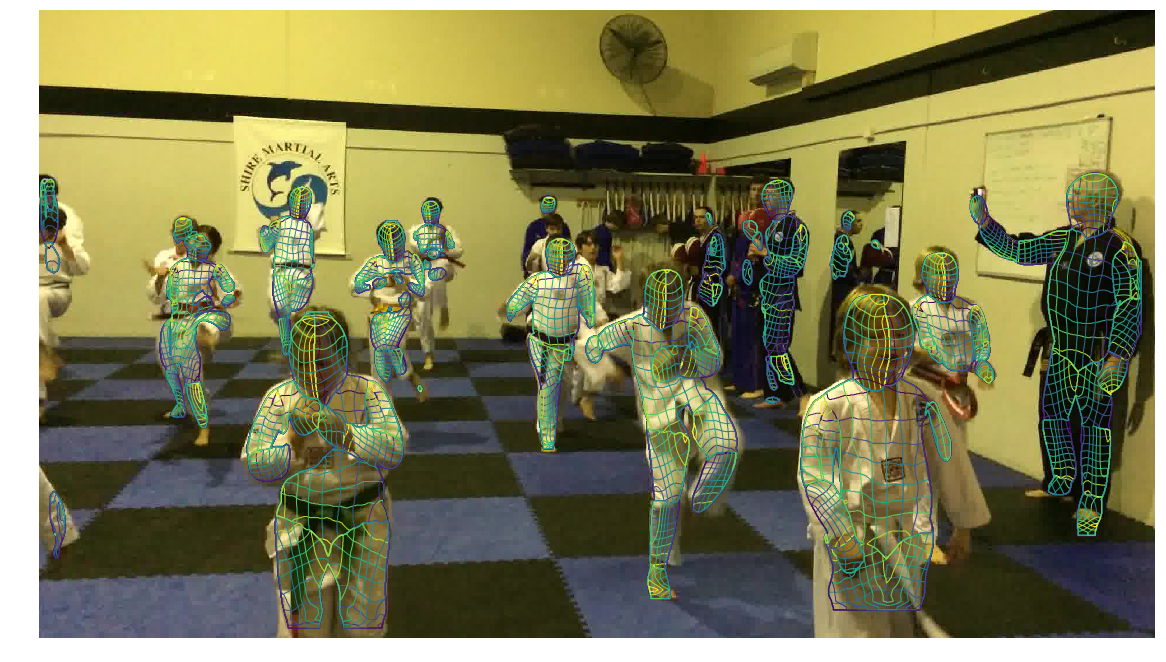

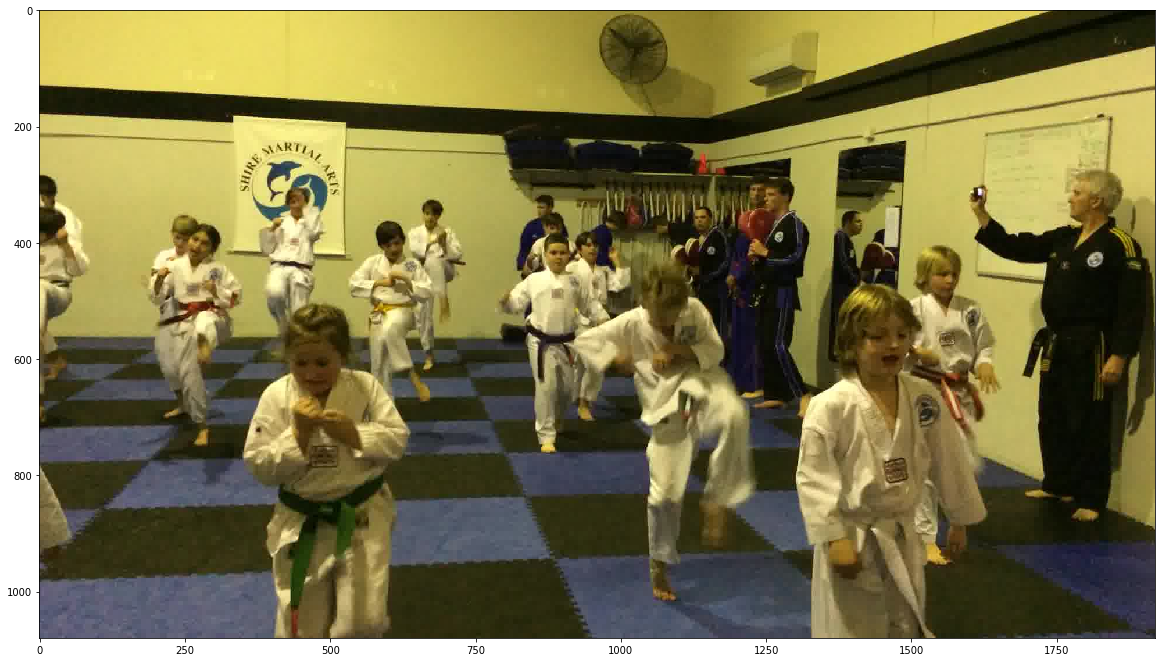

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

#im  = cv2.imread(join(project_name, 'DensePoseData/demo_data/demo_im.jpg'))
#IUV = cv2.imread(join(project_name, 'DensePoseData/infer_out/demo_im_IUV.png'))
#INDS = cv2.imread(join(project_name, 'DensePoseData/infer_out/demo_im_INDS.png'),  0)

#im = cv2.imread("/content/data/densepose_src/_DSC6563.jpg")
#IUV = cv2.imread("/content/data/densepose/infer_out/_DSC6563_IUV.png")
#INDS = cv2.imread("/content/data/densepose/infer_out/_DSC6563_INDS.png")

basePath = "/content/data/densePose_vid1/src"
filesToProcess = ["{0}/{1}".format(basePath, x) for x in os.listdir(basePath) if x.count("jpg")]

filesToProcess.sort()
print(filesToProcess)

for f in filesToProcess[140:]:
    im = cv2.imread(f)
    tokens = f.split("/")[-1].split(".")
    basePath2 = "/content/data/densePose_vid1/infer_out"
    iuvPath = "{0}/{1}_IUV.png".format(basePath2, tokens[0])
    indsPath = "{0}/{1}_INDS.png".format(basePath2, tokens[0])
    savePath = "{0}/{1}_save.png".format(basePath2, tokens[0])

    print(savePath)
    assert os.path.isfile(iuvPath)
    assert os.path.isfile(indsPath)
    
    IUV = cv2.imread(iuvPath)
    INDS = cv2.imread(indsPath)
    
    fig = plt.figure(figsize=[20, 20])
    plt.imshow( im[:,:,::-1] )
    plt.contour( IUV[:,:,1]/256.,10, linewidths = 1 )
    plt.contour( IUV[:,:,2]/256.,10, linewidths = 1 )
    plt.axis('off') 
    plt.savefig(savePath)
    #plt.show()

In [0]:
!cp -r /content/data/densePose_vid1/infer_out/ /content/drive/My\ Drive/MachineLearning/trainingSets/myRandomStuff_v1/densePose_infer_out7/

In [7]:
%cd /content/data/densePose_vid1/infer_out/
%ls -l *pdf

/content/data/densePose_vid1/infer_out
-rw-r--r-- 1 root root 1757095 Jun  7 11:53 IMG_0357_00001.jpg.pdf
-rw-r--r-- 1 root root 1782372 Jun  7 11:52 IMG_0357_00002.jpg.pdf
-rw-r--r-- 1 root root 1907749 Jun  7 11:53 IMG_0357_00003.jpg.pdf
-rw-r--r-- 1 root root 1827722 Jun  7 11:51 IMG_0357_00004.jpg.pdf
-rw-r--r-- 1 root root 1641671 Jun  7 11:51 IMG_0357_00005.jpg.pdf
-rw-r--r-- 1 root root 1472607 Jun  7 11:50 IMG_0357_00006.jpg.pdf
-rw-r--r-- 1 root root 1404138 Jun  7 11:51 IMG_0357_00007.jpg.pdf
-rw-r--r-- 1 root root 1327782 Jun  7 11:51 IMG_0357_00008.jpg.pdf
-rw-r--r-- 1 root root 1247576 Jun  7 11:52 IMG_0357_00009.jpg.pdf
-rw-r--r-- 1 root root 1177206 Jun  7 11:52 IMG_0357_00010.jpg.pdf
-rw-r--r-- 1 root root 1117474 Jun  7 11:49 IMG_0357_00011.jpg.pdf
-rw-r--r-- 1 root root 1105098 Jun  7 11:49 IMG_0357_00012.jpg.pdf
-rw-r--r-- 1 root root 1043047 Jun  7 11:51 IMG_0357_00013.jpg.pdf
-rw-r--r-- 1 root root 1002407 Jun  7 11:52 IMG_0357_00014.jpg.pdf
-rw-r--r-- 1 root root 

In [3]:
%cd /content/data/densePose_vid1/infer_out/

!ffmpeg -r 25 -f image2 -i IMG_0357_%05d_save.png -vcodec libx264 -crf 10 -pix_fmt yuv420p IMG_0357.mp4

/content/data/densePose_vid1/infer_out
ffmpeg version 3.4.6-0ubuntu0.18.04.1 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.3.0-16ubuntu3)
  configuration: --prefix=/usr --extra-version=0ubuntu0.18.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 